In [72]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras.utils import to_categorical


In [74]:

extraction_folder = '/content/drive/MyDrive/IAM_extraction'
d = {}
with open(f'{extraction_folder}/forms_for_parsing.txt') as f:
    for line in f:
        key, writer = line.split()[:2]
        d[key] = writer
print(len(d.keys()))

1539


In [75]:

tmp = []
target_list = []

path_to_files = os.path.join(f'{extraction_folder}/data_subset/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
    if os.stat(filename).st_size == 0:
        print(f"Bad file (0 bytes): {filename}")
        continue

    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    key = parts[0] + '-' + parts[1]
    if key in d:
        target_list.append(d[key])

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


In [76]:
# load images
images = []
for file in img_files:
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    images.append(image)

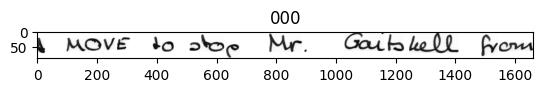

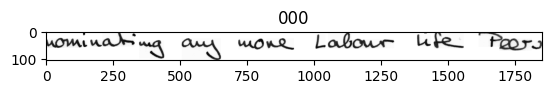

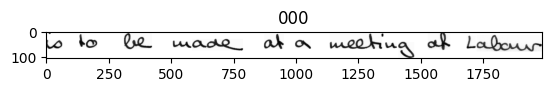

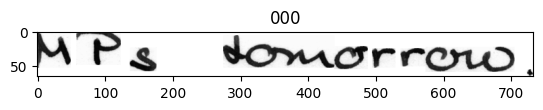

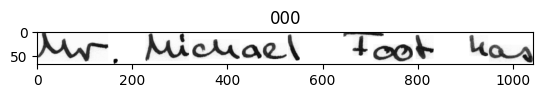

In [77]:
# visualize images and target
for i in range(5):
    image = images[i]
    label = img_targets[i]
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.show()

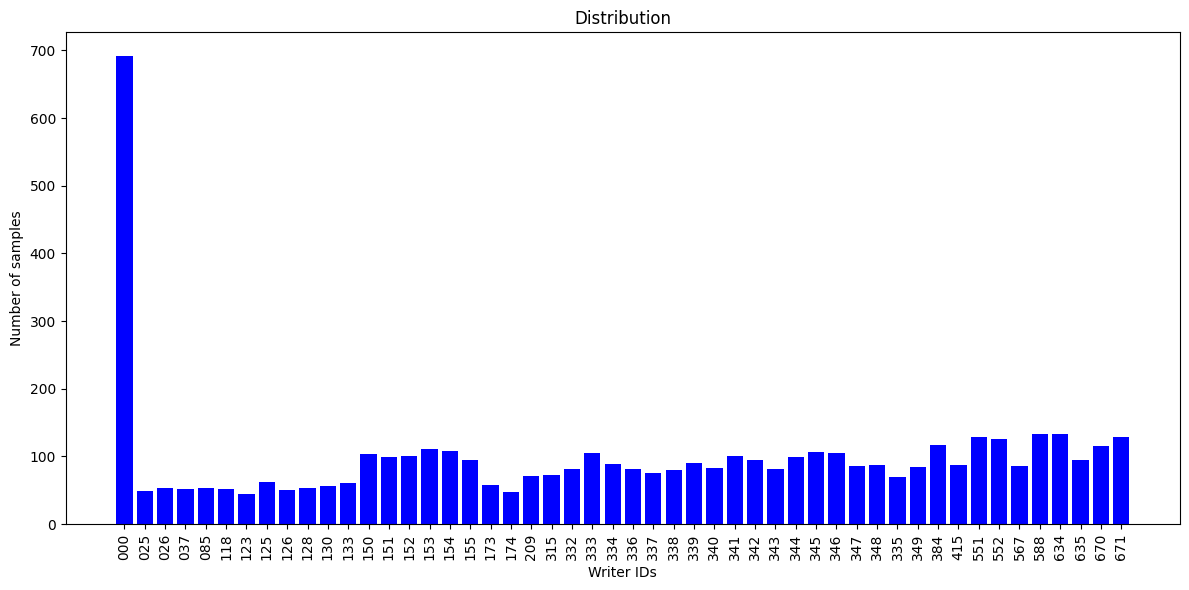

In [78]:

label_count = {}
for label in img_targets:
    if label in label_count:
        label_count[label]+=1
    else:
        label_count[label] = 1

label = list(label_count.keys())
counts = list(label_count.values())

plt.figure(figsize=(12, 6))
plt.bar(label, counts, color='blue')
plt.xlabel('Writer IDs')
plt.ylabel('Number of samples')
plt.title('Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [79]:
# preprocessing
# encode the label
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets) #  0, 1, 2, ...

In [80]:
Y = to_categorical(encoded_Y)
Y # one-hot vector (1, 0, 0, ...), (0, 1, 0, ...)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [81]:
# resize image and convert 2d image into 1d vector
X = []
for image in images:
    image = cv2.resize(image, (500, 50))
    X.append(image)
X = np.array(X) / 255.0
# the shape of X is (num of sample, height, width)
X = X.reshape(X.shape[0], -1)
# (num of sample, number of feature)
X.shape

(4899, 25000)

In [82]:

num_classes = max(encoded_Y) + 1
num_classes

50

## 1. Perceptron

In [83]:
# perceptron
perceptron_model = keras.Sequential(
    [
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

perceptron_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [84]:
# train the model
history = perceptron_model.fit(X, Y, epochs=30, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/30
123/123 [==============================] - 2s 9ms/step - loss: 11.1381 - accuracy: 0.0987 - val_loss: 4.3783 - val_accuracy: 0.0000e+00
Epoch 2/30
123/123 [==============================] - 1s 7ms/step - loss: 3.8334 - accuracy: 0.1615 - val_loss: 4.3256 - val_accuracy: 0.0000e+00
Epoch 3/30
123/123 [==============================] - 1s 7ms/step - loss: 3.6826 - accuracy: 0.1664 - val_loss: 8.5520 - val_accuracy: 0.0000e+00
Epoch 4/30
123/123 [==============================] - 1s 7ms/step - loss: 3.5103 - accuracy: 0.1766 - val_loss: 9.1258 - val_accuracy: 0.0000e+00
Epoch 5/30
123/123 [==============================] - 1s 7ms/step - loss: 3.4472 - accuracy: 0.1766 - val_loss: 8.3136 - val_accuracy: 0.0000e+00
Epoch 6/30
123/123 [==============================] - 1s 7ms/step - loss: 3.4102 - accuracy: 0.1766 - val_loss: 11.3362 - val_accuracy: 0.0000e+00
Epoch 7/30
123/123 [==============================] - 1s 7ms/step - loss: 3.3992 - accuracy: 0.1766 - val_loss: 7.8260 - v

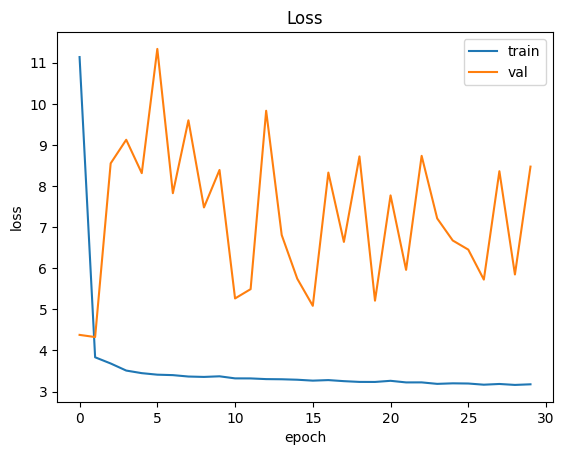

In [85]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

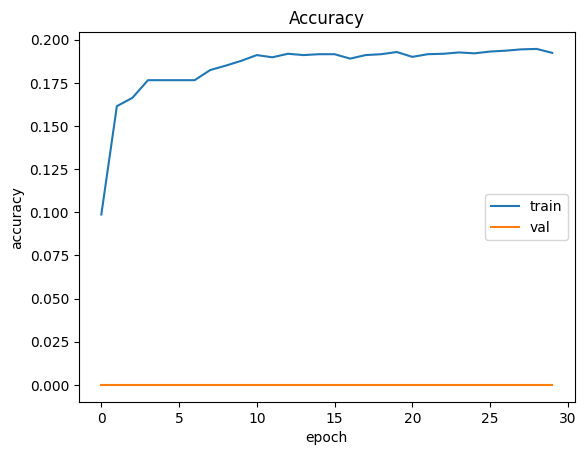

In [86]:

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## 2. MLP

In [87]:
from tensorflow import keras

# perceptron with multiple layers
mlp_model = keras.Sequential(
    [
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [88]:
# train themodel
history = mlp_model.fit(X, Y, epochs=30, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/30
123/123 [==============================] - 2s 11ms/step - loss: 6.1455 - accuracy: 0.1490 - val_loss: 9.3662 - val_accuracy: 0.0000e+00
Epoch 2/30
123/123 [==============================] - 1s 7ms/step - loss: 3.5048 - accuracy: 0.1725 - val_loss: 5.7750 - val_accuracy: 0.0000e+00
Epoch 3/30
123/123 [==============================] - 1s 7ms/step - loss: 3.4415 - accuracy: 0.1819 - val_loss: 9.3725 - val_accuracy: 0.0000e+00
Epoch 4/30
123/123 [==============================] - 1s 7ms/step - loss: 3.3755 - accuracy: 0.1891 - val_loss: 9.1432 - val_accuracy: 0.0000e+00
Epoch 5/30
123/123 [==============================] - 1s 7ms/step - loss: 3.3025 - accuracy: 0.1911 - val_loss: 13.3474 - val_accuracy: 0.0000e+00
Epoch 6/30
123/123 [==============================] - 1s 7ms/step - loss: 3.2752 - accuracy: 0.1909 - val_loss: 10.2421 - val_accuracy: 0.0000e+00
Epoch 7/30
123/123 [==============================] - 1s 7ms/step - loss: 3.2438 - accuracy: 0.1967 - val_loss: 9.5378 - 

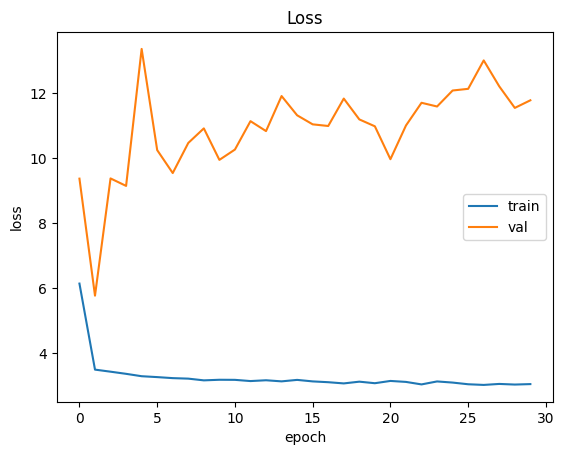

In [89]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

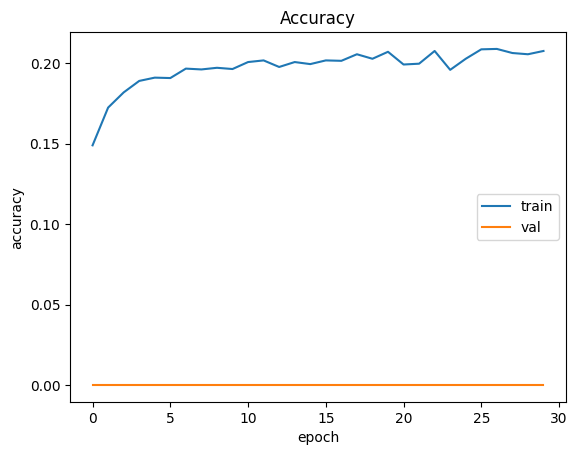

In [90]:

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## 3. DecisionTreeClassifier

In [91]:
from sklearn.model_selection import train_test_split

# Split the data - using the same `X` and `Y` from your preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [92]:
# demensional reduction based on PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix

# Create Decision Tree classifer object
dtree = DecisionTreeClassifier()

# Train Decision Tree Classifer
dtree = dtree.fit(X_train, y_train)
# Predict the response for the test dataset
y_pred = dtree.predict(X_test)


# Model Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Additional metrics
dt_report = classification_report(y_test, y_pred, output_dict=True)
print(dt_report)

Accuracy: 0.1878
{'0': {'precision': 0.5107913669064749, 'recall': 0.44654088050314467, 'f1-score': 0.476510067114094, 'support': 159}, '1': {'precision': 0.07142857142857142, 'recall': 0.1111111111111111, 'f1-score': 0.08695652173913043, 'support': 9}, '2': {'precision': 0.08333333333333333, 'recall': 0.1, 'f1-score': 0.0909090909090909, 'support': 10}, '3': {'precision': 0.16666666666666666, 'recall': 0.07142857142857142, 'f1-score': 0.1, 'support': 14}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11}, '6': {'precision': 0.05555555555555555, 'recall': 0.1, 'f1-score': 0.07142857142857142, 'support': 10}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '9': {'precision': 0.3, 'recall': 0.3333333333333333, 'f1-score': 0.3157894736842105, 'support': 9}, '10': {'precision': 0.0, 'recall': 0.0, 'f1-sco

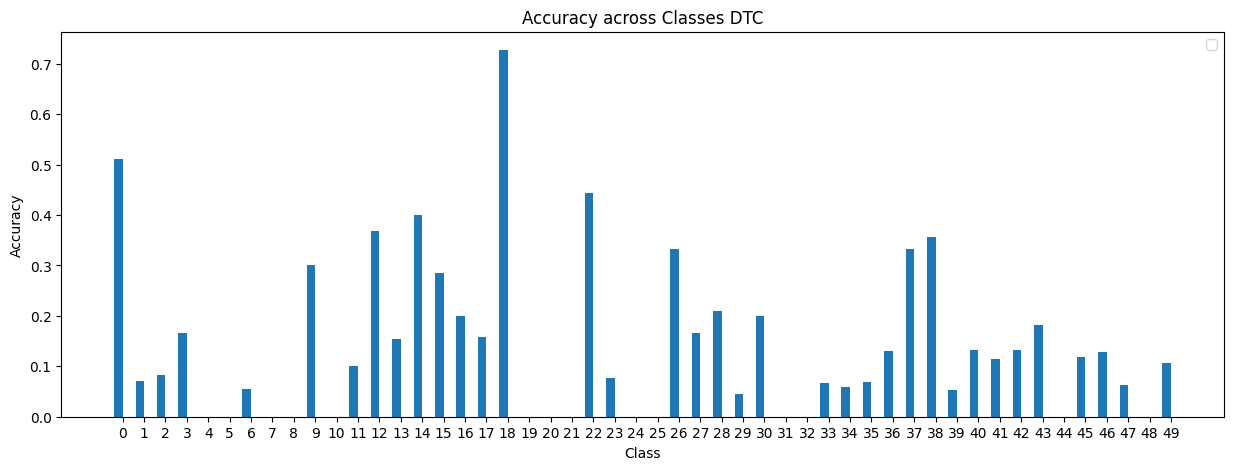

In [94]:
# plot the accuracy distributions for each label
dt_precision = [dt_report[key]['precision'] for key in list(dt_report.keys())[:-4]]

Xs = [str(i) for i in range(num_classes)]
X_axis = np.arange(num_classes)

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, dt_precision, 0.4)
plt.xticks(X_axis, Xs)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy across Classes DTC')
plt.legend()
plt.show()

## 4. RandomForestClassifier

In [95]:
# preprocessing all the image is narrow (100, 1500) -> several (100, 100) patch images
from sklearn.ensemble import RandomForestClassifier

# Create Decision Tree classifer object
rfc = RandomForestClassifier()

# Train Decision Tree Classifer
rfc = rfc.fit(X_train, y_train)
# Predict the response for the test dataset
y_pred = rfc.predict(X_test)

# Model Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Additional metrics
rfc_report = classification_report(y_test, y_pred, output_dict=True)
print(rfc_report)

Accuracy: 0.0306
{'0': {'precision': 0.90625, 'recall': 0.18238993710691823, 'f1-score': 0.3036649214659686, 'support': 159}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}, '11': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17}, '12': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 26}, '13': {'pr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


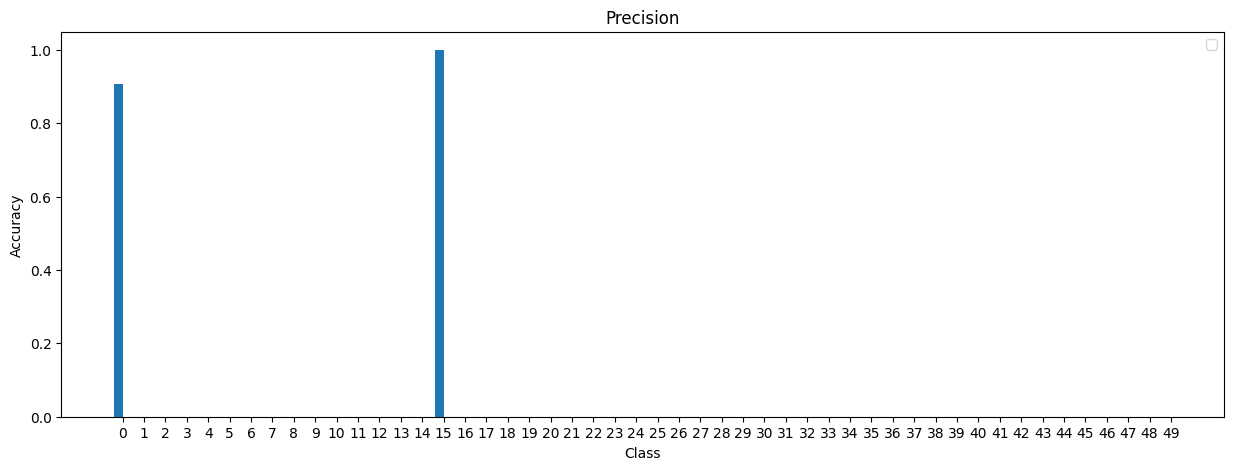

In [96]:
# plot the accuracy distributions for each label
rfc_precision = [rfc_report[key]['precision'] for key in list(rfc_report.keys())[:-4]]

Xs = [str(i) for i in range(num_classes)]
X_axis = np.arange(num_classes)

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, rfc_precision, 0.4)
plt.xticks(X_axis, Xs)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Precision')
plt.legend()
plt.show()

## 5. KNN

In [97]:
# add KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create KNN classifer object
knn = KNeighborsClassifier()

# Train KNN Classifer
knn = knn.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = knn.predict(X_test)

# Model Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Additional metrics
knn_report = classification_report(y_test, y_pred, output_dict=True)
print(knn_report)

Accuracy: 0.0898
{'0': {'precision': 1.0, 'recall': 0.12578616352201258, 'f1-score': 0.223463687150838, 'support': 159}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '9': {'precision': 0.6, 'recall': 0.6666666666666666, 'f1-score': 0.631578947368421, 'support': 9}, '10': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}, '11': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17}, '12': {'precision': 0.6666666666666666, 'recall': 0.2307692

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


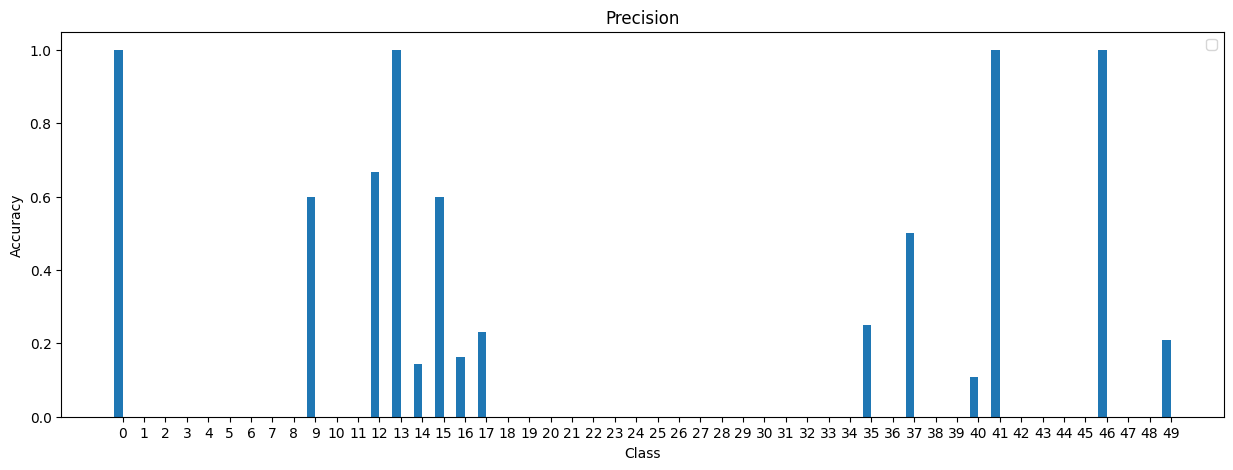

In [98]:
# plot the accuracy distributions for each label
knn_precision = [knn_report[key]['precision'] for key in list(knn_report.keys())[:-4]]


Xs = [str(i) for i in range(num_classes)]
X_axis = np.arange(num_classes)

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, knn_precision, 0.4)
plt.xticks(X_axis, Xs)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Precision')
plt.legend()
plt.show()

## 6. SVM

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, encoded_Y, test_size=0.2, random_state=42)

pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [100]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report


svc = svm.SVC()

svc = svc.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = svc.predict(X_test)

# Model Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Additional metrics
svc_report = classification_report(y_test, y_pred, output_dict=True)
print(svc_report)

Accuracy: 0.3939
{'0': {'precision': 0.42032967032967034, 'recall': 0.9622641509433962, 'f1-score': 0.5850860420650095, 'support': 159}, '1': {'precision': 0.3333333333333333, 'recall': 0.2222222222222222, 'f1-score': 0.26666666666666666, 'support': 9}, '2': {'precision': 0.5, 'recall': 0.1, 'f1-score': 0.16666666666666669, 'support': 10}, '3': {'precision': 0.6666666666666666, 'recall': 0.14285714285714285, 'f1-score': 0.23529411764705882, 'support': 14}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11}, '6': {'precision': 1.0, 'recall': 0.1, 'f1-score': 0.18181818181818182, 'support': 10}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10}, '9': {'precision': 0.75, 'recall': 0.3333333333333333, 'f1-score': 0.46153846153846156, 'support': 9}, '10': {'precision': 1.0, 'recall': 0.08333333333333333, 'f1-s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


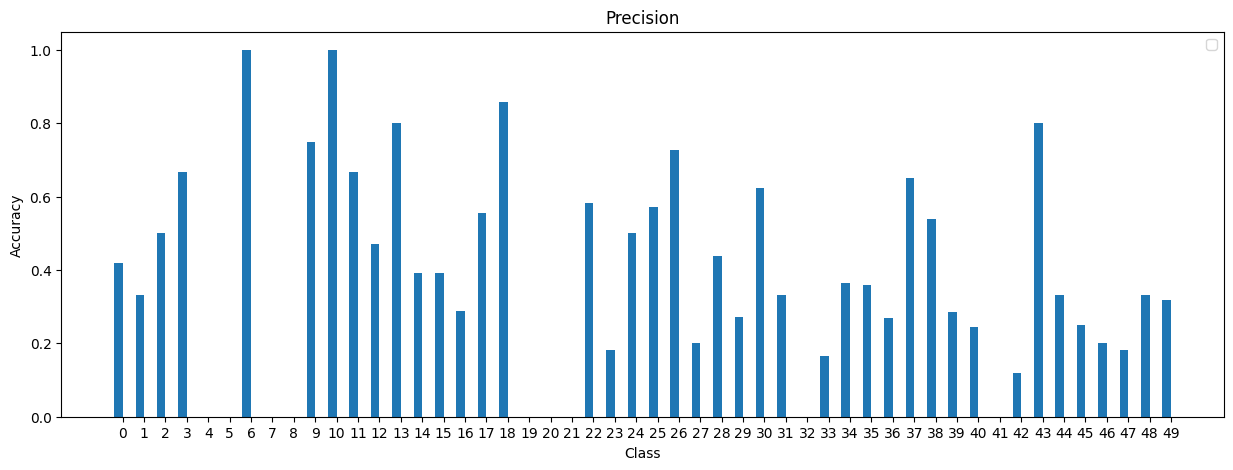

In [101]:
# plot the accuracy distributions for each label
svc_precision = [svc_report[key]['precision'] for key in list(svc_report.keys())[:-3]]

Xs = [str(i) for i in range(num_classes)]
X_axis = np.arange(num_classes)

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, svc_precision, 0.4)
plt.xticks(X_axis, Xs)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Precision')
plt.legend()
plt.show()

## Split data for CNN model

In [102]:
train_files, test_files, train_targets, test_targets = train_test_split(
        img_files, encoded_Y, train_size=0.8, random_state=1, shuffle= True)

print(train_files.shape, test_files.shape)

(3919,) (980,)


## 7. Simple CNN model

In [103]:
from PIL import Image
import random
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 56x56 patches from these images

batch_size = 16
num_classes = 50
image_width = 512
image_height = 64

# Start with train generator shared in the class and add image augmentations
def generate_data1(samples, target_files, batch_size=batch_size):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)

                imresize = im.resize((image_width, image_height), Image.ANTIALIAS)
                images.append(np.asarray(imresize))
                targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            # add a new aixs in X_train for feeding in later
            X_train = np.expand_dims(X_train, axis=3)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

In [104]:
train_gen1 = generate_data1(train_files, train_targets, batch_size=batch_size)
test_gen1 = generate_data1(test_files, test_targets, batch_size=batch_size)

<ipython-input-103-cfa034e37444>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((image_width, image_height), Image.ANTIALIAS)


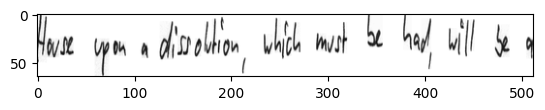

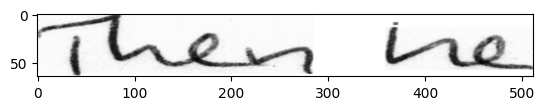

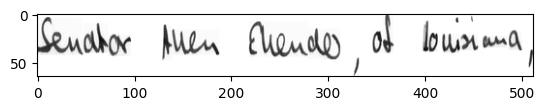

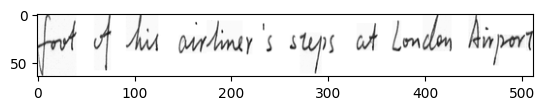

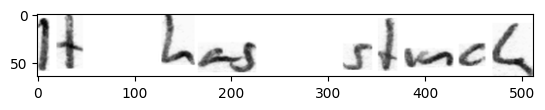

In [105]:
# visualize sample images
for x, y in train_gen1:
    for i in range(5):
        image = x[i]
        plt.imshow(image, cmap='gray')
        plt.show()
    break

In [106]:
# build a cnn model
from tensorflow import keras

cnn_model1 = keras.Sequential(
    [
        keras.layers.Conv2D(32, 5, 2, padding="same", input_shape=(64, 512, 1)),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(),
        keras.layers.Conv2D(64, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(),
        keras.layers.Conv2D(128, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

cnn_model1.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics='accuracy')
cnn_model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 256, 32)       832       
                                                                 
 re_lu_9 (ReLU)              (None, 32, 256, 32)       0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 128, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 128, 64)       18496     
                                                                 
 re_lu_10 (ReLU)             (None, 16, 128, 64)       0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 8, 64, 64)         0         
 ng2D)                                                

In [107]:
history = cnn_model1.fit_generator(train_gen1, epochs=30,
                                  steps_per_epoch=len(train_files)/batch_size,
                                  validation_data=test_gen1,
                                  validation_steps=len(test_files)/batch_size,
                                  verbose=1)

Epoch 1/30


<ipython-input-107-c09265e33e63>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn_model1.fit_generator(train_gen1, epochs=30,
<ipython-input-103-cfa034e37444>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((image_width, image_height), Image.ANTIALIAS)


244/244 [==============================] - 18s 70ms/step - loss: 3.3819 - accuracy: 0.1745 - val_loss: 2.3832 - val_accuracy: 0.2898
Epoch 2/30
244/244 [==============================] - 17s 70ms/step - loss: 1.7242 - accuracy: 0.4726 - val_loss: 1.5707 - val_accuracy: 0.5163
Epoch 3/30
244/244 [==============================] - 17s 69ms/step - loss: 1.1183 - accuracy: 0.6568 - val_loss: 1.3789 - val_accuracy: 0.5888
Epoch 4/30
244/244 [==============================] - 17s 69ms/step - loss: 0.6873 - accuracy: 0.7910 - val_loss: 2.2958 - val_accuracy: 0.4551
Epoch 5/30
244/244 [==============================] - 17s 69ms/step - loss: 0.4056 - accuracy: 0.8742 - val_loss: 2.2793 - val_accuracy: 0.5276
Epoch 6/30
244/244 [==============================] - 16s 65ms/step - loss: 0.2051 - accuracy: 0.9403 - val_loss: 2.0992 - val_accuracy: 0.6071
Epoch 7/30
244/244 [==============================] - 14s 59ms/step - loss: 0.1777 - accuracy: 0.9474 - val_loss: 2.1202 - val_accuracy: 0.6184
Epo

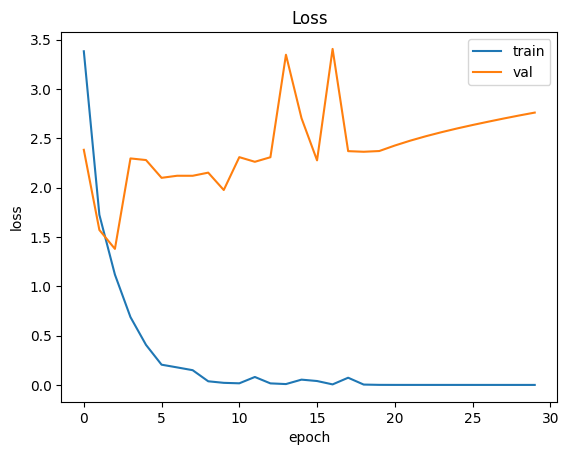

In [108]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

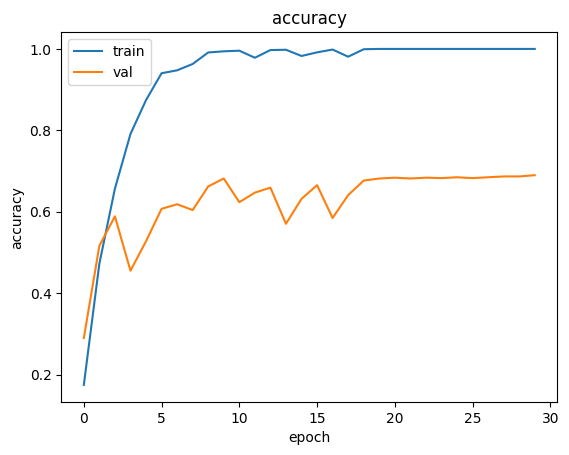

In [109]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [110]:
correct = 0
y_preds = []
for x, y in zip(test_files, test_targets):
    im = Image.open(x)
    imresize = im.resize((image_width, image_height), Image.ANTIALIAS)
    image = np.array(imresize) / 255.
    image = image.reshape((1, image_height, image_width, 1))
    y_pred = cnn_model1.predict(image, verbose=0)[0]
    y_pred = y_pred.argmax()
    y_preds.append(y_pred)

y_preds = np.array(y_preds)
cnn_report1 = classification_report(test_targets, y_preds, output_dict=True)
accuracy = np.mean(y_preds == test_targets)
print("Test accuracy: ", accuracy)

<ipython-input-110-ceb5f027edd6>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((image_width, image_height), Image.ANTIALIAS)


Test accuracy:  0.689795918367347


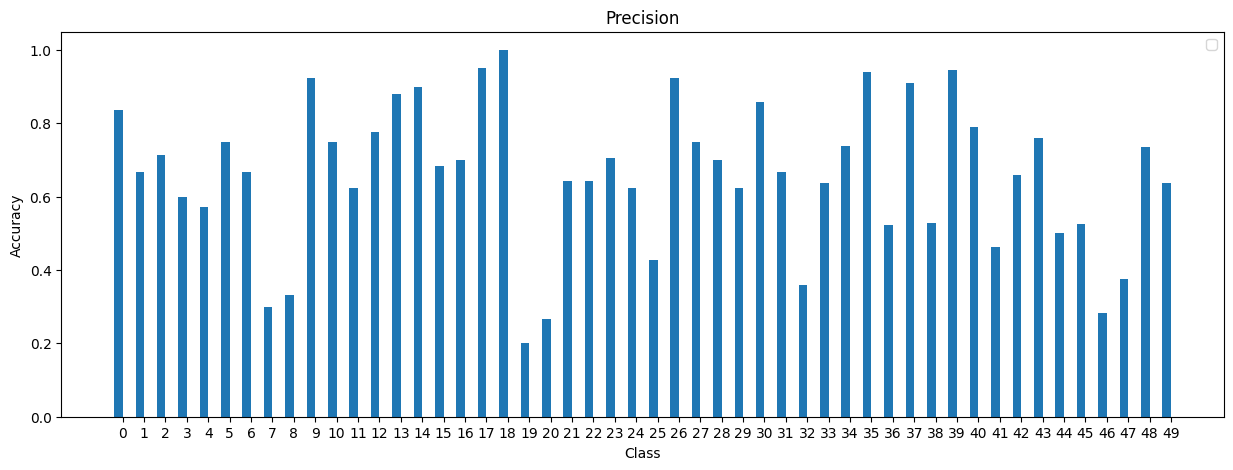

In [111]:
# plot the accuracy distributions for each label
cnn_precision = [cnn_report1[key]['precision'] for key in list(cnn_report1.keys())[:-3]]

Xs = [str(i) for i in range(num_classes)]
X_axis = np.arange(num_classes)

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, cnn_precision, 0.4)
plt.xticks(X_axis, Xs)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Precision')
plt.legend()
plt.show()

## 8. CNN Model (2)

In [112]:
from PIL import Image
import random
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 56x56 patches from these images

batch_size = 8 #16
num_classes = 50
image_size = 56

# Start with train generator shared in the class and add image augmentations
def generate_data2(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = image_size / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, image_size

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 112 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 112x112 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - image_size ))# total x start points are from 0 to width -112

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = random.sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+image_size, image_size))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            # add a new aixs in X_train for feeding in later
            X_train = np.expand_dims(X_train, axis=3)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

In [113]:
train_gen2 = generate_data2(train_files, train_targets, batch_size=batch_size, factor = 0.1)
test_gen2 = generate_data2(test_files, test_targets, batch_size=batch_size, factor = 0.1)

<ipython-input-112-17e8051c031c>:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 112 while keeping aspect ratio


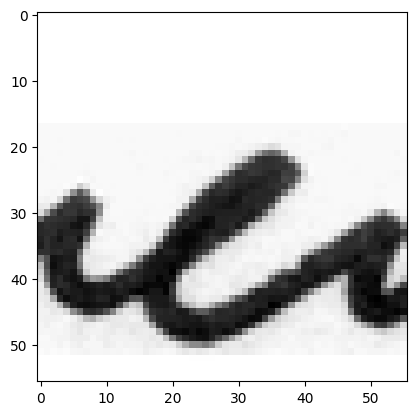

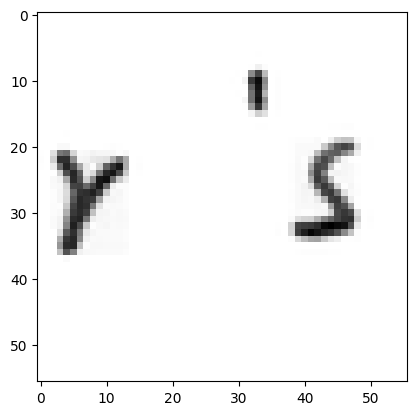

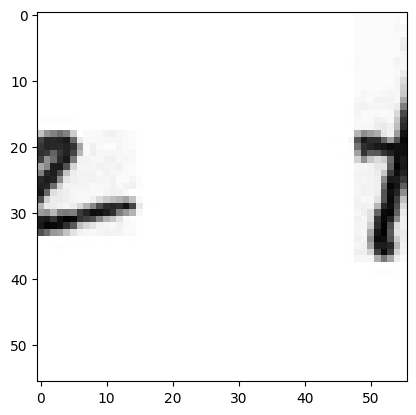

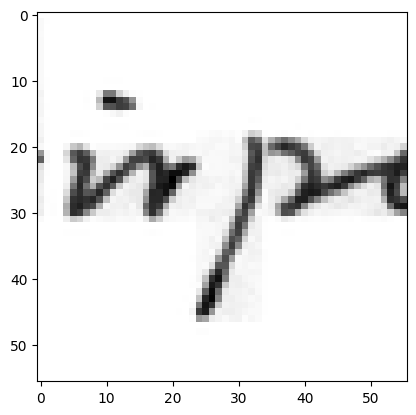

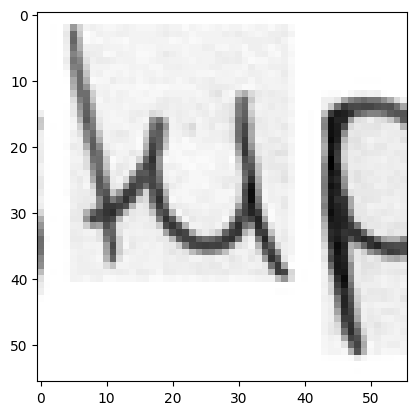

In [114]:
# visualize sample images
for x, y in train_gen2:
    for i in range(5):
        image = x[i]
        plt.imshow(image, cmap='gray')
        plt.show()
    break

In [115]:
# build a cnn model
cnn_model2 = keras.Sequential(
    [
        keras.layers.Conv2D(32, 5, 2, padding="same", input_shape=(56, 56, 1)),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(),
        keras.layers.Conv2D(64, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(),
        keras.layers.Conv2D(128, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

cnn_model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics='accuracy')
cnn_model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 re_lu_12 (ReLU)             (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 re_lu_13 (ReLU)             (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                

In [116]:
history = cnn_model2.fit_generator(train_gen2, epochs=30,
                                  steps_per_epoch=len(train_files)/batch_size,
                                  validation_data=test_gen2,
                                  validation_steps=len(test_files)/batch_size,
                                  verbose=1)

Epoch 1/30


<ipython-input-116-1019e83a49ae>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn_model2.fit_generator(train_gen2, epochs=30,
<ipython-input-112-17e8051c031c>:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 112 while keeping aspect ratio


489/489 [==============================] - 28s 54ms/step - loss: 3.4703 - accuracy: 0.2135 - val_loss: 2.7950 - val_accuracy: 0.2688
Epoch 2/30
489/489 [==============================] - 26s 54ms/step - loss: 2.4435 - accuracy: 0.3237 - val_loss: 1.9230 - val_accuracy: 0.4447
Epoch 3/30
489/489 [==============================] - 26s 54ms/step - loss: 1.7760 - accuracy: 0.4799 - val_loss: 1.5256 - val_accuracy: 0.5436
Epoch 4/30
489/489 [==============================] - 26s 53ms/step - loss: 1.4648 - accuracy: 0.5597 - val_loss: 1.3462 - val_accuracy: 0.5951
Epoch 5/30
489/489 [==============================] - 26s 54ms/step - loss: 1.2920 - accuracy: 0.6097 - val_loss: 1.1753 - val_accuracy: 0.6443
Epoch 6/30
489/489 [==============================] - 26s 53ms/step - loss: 1.1693 - accuracy: 0.6465 - val_loss: 1.0668 - val_accuracy: 0.6792
Epoch 7/30
489/489 [==============================] - 26s 53ms/step - loss: 1.0488 - accuracy: 0.6816 - val_loss: 0.9873 - val_accuracy: 0.6998
Epo

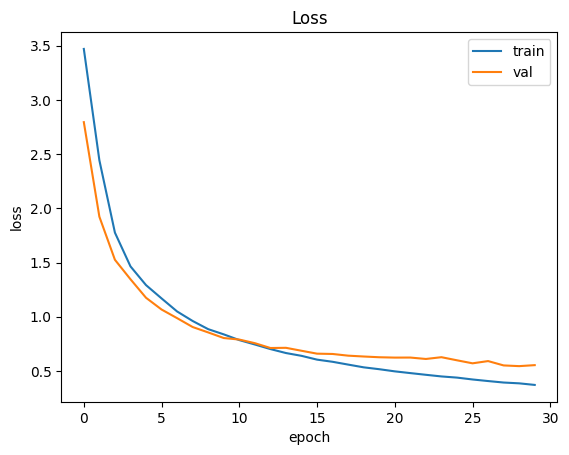

In [117]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

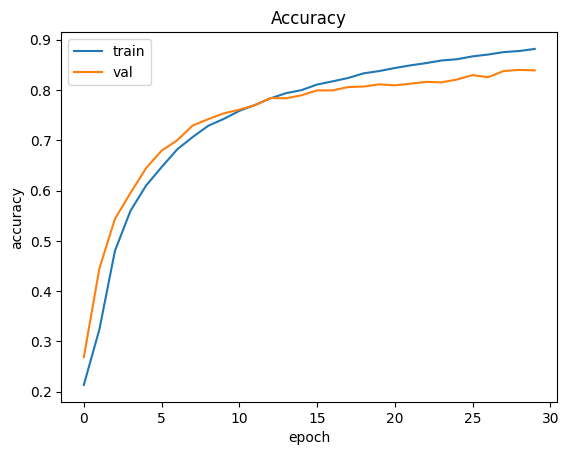

In [118]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [119]:
# predict function
def predict(model, image_path):
    im = Image.open(image_path)
    cur_width = im.size[0]
    cur_height = im.size[1]

    # print(cur_width, cur_height)
    height_fac = image_size / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, image_size

    imresize = im.resize((size), Image.ANTIALIAS)
    # generate image patches
    images = []
    for start in range(0, new_width, image_size):
        imcrop = imresize.crop((start, 0, start+image_size, image_size))
        images.append(np.array(imcrop))

    images = np.array(images)
    images = np.expand_dims(images, axis=3) / 255.

    # predict
    y_preds = model.predict(images, verbose=0)
    # calculate class label for each patch
    y_pred = y_preds.argmax(axis=1)
    # find the highest frequent number
    counts = np.bincount(y_pred)
    label = np.argmax(counts)
    return label

In [120]:
correct = 0
y_preds = []
for x, y in zip(test_files, test_targets):
    y_pred = predict(cnn_model2, x)
    y_preds.append(y_pred)

y_preds = np.array(y_preds)
clf_report2 = classification_report(test_targets, y_preds, output_dict=True)
accuracy = np.mean(y_preds == test_targets)
print("Test accuracy: ", accuracy)

<ipython-input-119-6118c3967b76>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)


Test accuracy:  0.9163265306122449


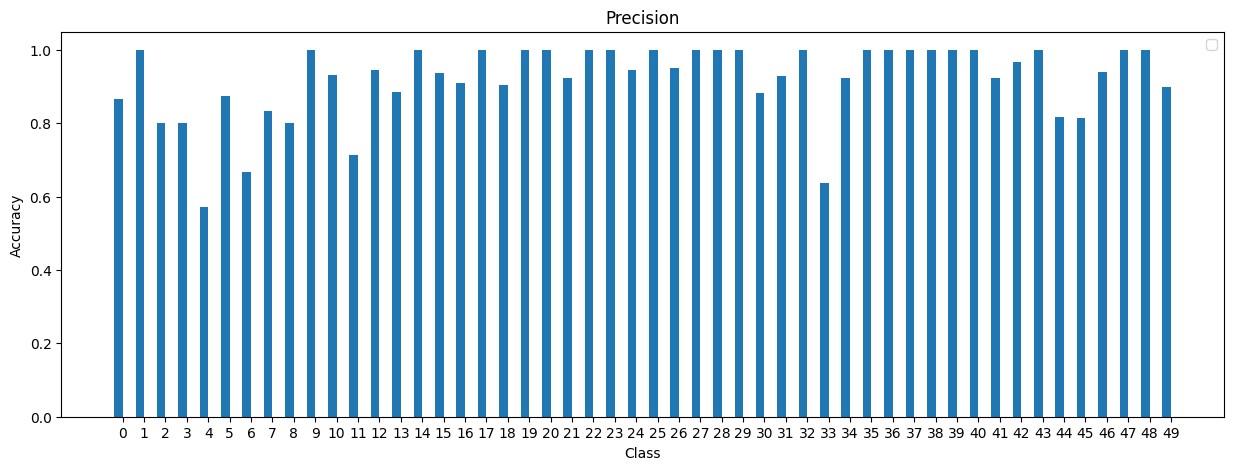

In [121]:
# plot the accuracy distributions for each label
cnn_precision = [clf_report2[key]['precision'] for key in list(clf_report2.keys())[:-3]]

Xs = [str(i) for i in range(num_classes)]
X_axis = np.arange(num_classes)

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, cnn_precision, 0.4)
plt.xticks(X_axis, Xs)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Precision')
plt.legend()
plt.show()

## 9. CNN Model (3)

In [122]:
# build a cnn model by adding dropout layers and setting weight decay for optimizer to prevent overfitting

cnn_model3 = keras.Sequential(
    [
        keras.layers.Conv2D(32, 5, 2, padding="same", input_shape=(56, 56, 1)),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(),
        keras.layers.Conv2D(64, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(),
        keras.layers.Conv2D(128, 3, padding="same"),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

cnn_model3.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001, weight_decay=1e-4), metrics='accuracy')
cnn_model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 re_lu_15 (ReLU)             (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 re_lu_16 (ReLU)             (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                               

In [123]:
history = cnn_model3.fit_generator(train_gen2, epochs=30,
                                  steps_per_epoch=len(train_files)/batch_size,
                                  validation_data=test_gen2,
                                  validation_steps=len(test_files)/batch_size,
                                  verbose=1)

Epoch 1/30


<ipython-input-123-14580a69748c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn_model3.fit_generator(train_gen2, epochs=30,
<ipython-input-112-17e8051c031c>:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 112 while keeping aspect ratio


489/489 [==============================] - 28s 54ms/step - loss: 3.2596 - accuracy: 0.2245 - val_loss: 2.5405 - val_accuracy: 0.3258
Epoch 2/30
489/489 [==============================] - 26s 54ms/step - loss: 2.4577 - accuracy: 0.3157 - val_loss: 1.9099 - val_accuracy: 0.4624
Epoch 3/30
489/489 [==============================] - 26s 54ms/step - loss: 1.9471 - accuracy: 0.4308 - val_loss: 1.5305 - val_accuracy: 0.5534
Epoch 4/30
489/489 [==============================] - 26s 54ms/step - loss: 1.6419 - accuracy: 0.5058 - val_loss: 1.3557 - val_accuracy: 0.5845
Epoch 5/30
489/489 [==============================] - 26s 54ms/step - loss: 1.4547 - accuracy: 0.5584 - val_loss: 1.2300 - val_accuracy: 0.6212
Epoch 6/30
489/489 [==============================] - 26s 53ms/step - loss: 1.3199 - accuracy: 0.5973 - val_loss: 1.0806 - val_accuracy: 0.6649
Epoch 7/30
489/489 [==============================] - 26s 53ms/step - loss: 1.2165 - accuracy: 0.6266 - val_loss: 1.0382 - val_accuracy: 0.6738
Epo

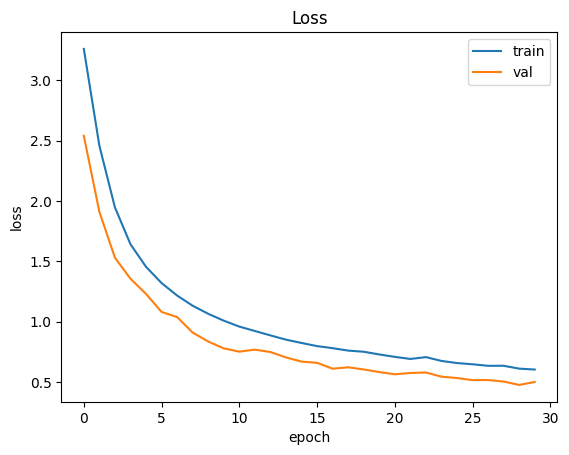

In [124]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

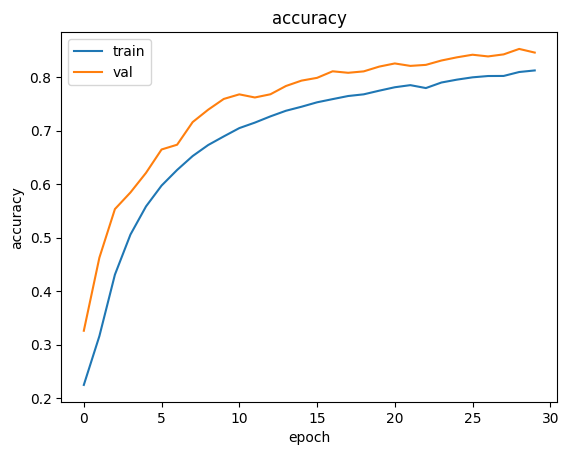

In [125]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [126]:
correct = 0
y_preds = []
for x, y in zip(test_files, test_targets):
    y_pred = predict(cnn_model3, x)
    y_preds.append(y_pred)

y_preds = np.array(y_preds)
cnn_report3 = classification_report(test_targets, y_preds, output_dict=True)
accuracy = np.mean(y_preds == test_targets)
print("Test accuracy: ", accuracy)

<ipython-input-119-6118c3967b76>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)


Test accuracy:  0.9193877551020408


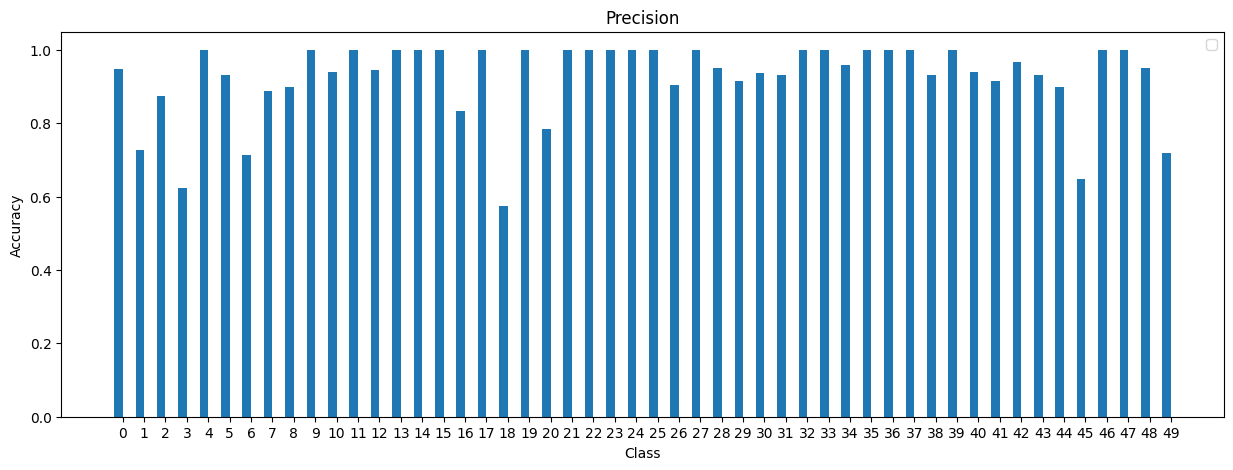

In [127]:
# plot the accuracy distributions for each label
clf_precision = [cnn_report3[key]['precision'] for key in list(cnn_report3.keys())[:-3]]

Xs = [str(i) for i in range(num_classes)]
X_axis = np.arange(num_classes)

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, clf_precision, 0.4)
plt.xticks(X_axis, Xs)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Precision')
plt.legend()
plt.show()

## 10. RNN

In [128]:
from PIL import Image
import random
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 56x56 patches from these images

batch_size = 16
num_classes = 50
image_width = 512
image_height = 64

# Start with train generator shared in the class and add image augmentations
def generate_data3(samples, target_files, batch_size=batch_size):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)

                imresize = im.resize((image_width, image_height), Image.ANTIALIAS)
                images.append(np.asarray(imresize))
                targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            # transpose the shape (B, H, W) to (B, W, H) so the width is treated like time sequences
            X_train = X_train.transpose((0, 2, 1))
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

In [129]:
train_gen3 = generate_data3(train_files, train_targets, batch_size=batch_size)
test_gen3 = generate_data3(test_files, test_targets, batch_size=batch_size)

In [130]:
rnn_model = keras.Sequential(
    [
        keras.layers.LSTM(64, input_shape=(None, 64)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ]
)

rnn_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001, weight_decay=1e-4), metrics='accuracy')
rnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 256)               16640     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 50)                12850     
                                                                 
Total params: 62514 (244.20 KB)
Trainable params: 62514 (244.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [131]:
history = rnn_model.fit_generator(train_gen3, epochs=30,
                                  steps_per_epoch=len(train_files)/batch_size,
                                  validation_data=test_gen3,
                                  validation_steps=len(test_files)/batch_size,
                                  verbose=1)

Epoch 1/30


<ipython-input-131-315e992e9976>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = rnn_model.fit_generator(train_gen3, epochs=30,
<ipython-input-128-37336f5cd5c0>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((image_width, image_height), Image.ANTIALIAS)


244/244 [==============================] - 21s 77ms/step - loss: 3.7849 - accuracy: 0.1312 - val_loss: 3.7155 - val_accuracy: 0.1541
Epoch 2/30
244/244 [==============================] - 19s 78ms/step - loss: 3.7370 - accuracy: 0.1380 - val_loss: 3.6916 - val_accuracy: 0.1541
Epoch 3/30
244/244 [==============================] - 19s 79ms/step - loss: 3.7168 - accuracy: 0.1380 - val_loss: 3.6741 - val_accuracy: 0.1541
Epoch 4/30
244/244 [==============================] - 19s 78ms/step - loss: 3.6922 - accuracy: 0.1380 - val_loss: 3.6426 - val_accuracy: 0.1541
Epoch 5/30
244/244 [==============================] - 18s 75ms/step - loss: 3.6745 - accuracy: 0.1378 - val_loss: 3.6299 - val_accuracy: 0.1541
Epoch 6/30
244/244 [==============================] - 18s 73ms/step - loss: 3.6573 - accuracy: 0.1370 - val_loss: 3.5946 - val_accuracy: 0.1541
Epoch 7/30
244/244 [==============================] - 16s 66ms/step - loss: 3.6325 - accuracy: 0.1365 - val_loss: 3.5133 - val_accuracy: 0.1541
Epo

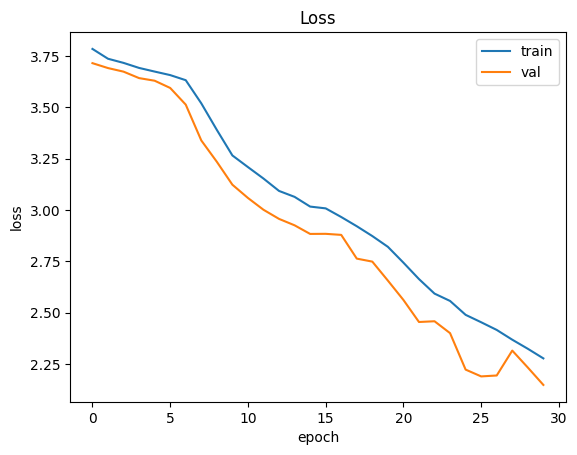

In [132]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

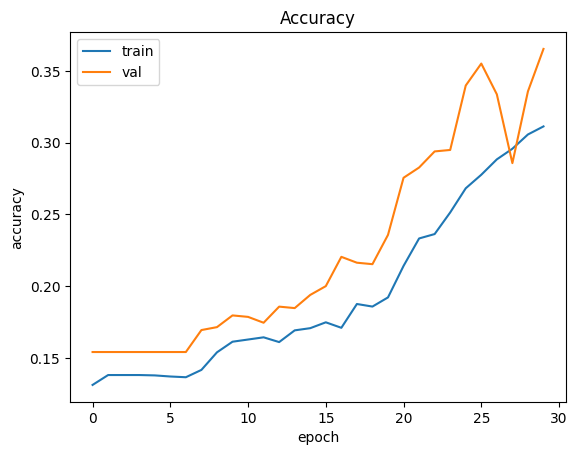

In [133]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [134]:
correct = 0
y_preds = []
for x, y in zip(test_files, test_targets):
    im = Image.open(x)
    imresize = im.resize((image_width, image_height), Image.ANTIALIAS)
    image = np.array(imresize) / 255.
    image = image.transpose((1, 0))
    image = image.reshape((1, image_width, image_height))
    y_pred = rnn_model.predict(image, verbose=0)[0]
    y_pred = y_pred.argmax()
    y_preds.append(y_pred)

y_preds = np.array(y_preds)
rnn_report = classification_report(test_targets, y_preds, output_dict=True)
accuracy = np.mean(y_preds == test_targets)
print("Test accuracy: ", accuracy)

<ipython-input-134-79bbf1b12478>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((image_width, image_height), Image.ANTIALIAS)


Test accuracy:  0.3653061224489796


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


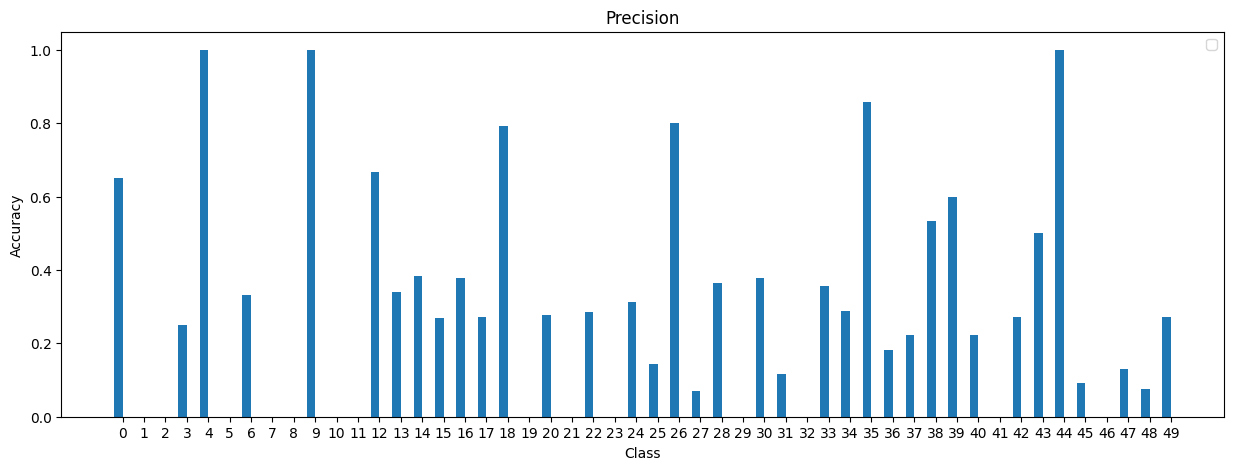

In [135]:
# plot the accuracy distributions for each label
clf_precision = [rnn_report[key]['precision'] for key in list(rnn_report.keys())[:-3]]

Xs = [str(i) for i in range(num_classes)]
X_axis = np.arange(num_classes)

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, clf_precision, 0.4)
plt.xticks(X_axis, Xs)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Precision')
plt.legend()
plt.show()